In [8]:
import pandas as pd
import DataLoading
import torch
import matplotlib.pyplot as plt
import NN_evaluation
import numpy as np 

In [27]:
sc = "sc01"
period = "2030"
case= "3-bus"
folder = f"../Data/{case}_DC_fy/"

all_executions = DataLoading.list_executions(folder=folder,per = period,sc=sc)
te_s = 0.3
val_s = 0.3
dfs_in, dfs_out, dfs_inter = DataLoading.load_data_ext_out(folder, all_executions, period, sc, ["PowerFlow"],"SystemCosts")
dfs_inter_j = DataLoading.join_frames_inter_layer(dfs_inter,all_executions)
dfs_inter_j = DataLoading.trim_columns_to_common(dfs_inter_j)
# Convert to pytorch tensors
ts_in, ts_out, ts_inter = DataLoading.split_tr_val_te_ext_out(dfs_in, dfs_out, dfs_inter_j, all_executions, te_s, val_s)
d_ft_in, d_ft_out, d_ft_inter,maxs = DataLoading.concat_and_normalize_ext_out(ts_in, ts_out, ts_inter, all_executions)

input_size = dfs_in["Network_Existing_Generation_Full"].shape[1]
inter_size = dfs_inter_j["Network_Existing_Generation_Full"].shape[1]

t_in_fy, t_out_fy, t_inter_fy, maxs = DataLoading.concat_all_exec_fy(dfs_in=dfs_in, dfs_out=dfs_out, dfs_inter_j=dfs_inter_j,executions=all_executions,normalize_out=True)


input_f_sc01_Network_Existing_Generation_Full_2030.csv
14
input_f_sc01_Network_Full_Generation_Full_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_1_Node_2_cac1_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_1_Node_2_cac2_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_1_Node_2_cac3_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_1_Node_3_cac1_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_1_Node_3_cac2_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_1_Node_3_cac3_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_2_Node_3_cac1_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_2_Node_3_cac2_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_2_Node_3_cac3_2030.csv
14
input_f_sc01_TOOT_Network_Line_In_Node_1_Node_2_cac1_2030.csv
14
input_f_sc01_TOOT_Network_Line_In_Node_1_Node_2_cac2_2030.csv
14
input_f_sc01_TOOT_Network_Line_In_Node_1_Node_2_cac3_2030.csv
14
input_f_sc01_TOOT_Network_Line_In_Node_1_Node_3_cac1_2030.csv
14
input_f_sc01_TOOT_Network_Line_In_Node_1_No

In [28]:
#Calculate some overall metrics such as variance 
torch.mean(t_in_fy,axis = 0)
print("Input standard dev:", torch.std(t_in_fy,axis = 0))

torch.mean(t_inter_fy,axis = 0)
print("Intermediate layer standard dev:",torch.std(t_inter_fy,axis = 0))

print("Output standard dev:",torch.std(t_out_fy,axis = 0))
torch.mean(t_out_fy,axis = 0)


Input standard dev: tensor([0.1405, 0.1122, 0.1228, 0.3096, 0.2013, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000], dtype=torch.float64)
Intermediate layer standard dev: tensor([0.2522, 0.4673, 0.2626], dtype=torch.float64)
Output standard dev: tensor(0.0899, dtype=torch.float64)


tensor(0.2397, dtype=torch.float64)

tensor(0.0914, dtype=torch.float64) tensor(2.3496e-13, dtype=torch.float64) tensor(0.1610, dtype=torch.float64)


{'whiskers': [<matplotlib.lines.Line2D at 0x22dbd55caf0>,
 'caps': [<matplotlib.lines.Line2D at 0x22dbd55d030>,
 'boxes': [<matplotlib.lines.Line2D at 0x22dbd55c850>],
 'medians': [<matplotlib.lines.Line2D at 0x22dbd55d570>],
 'fliers': [<matplotlib.lines.Line2D at 0x22dbd55d810>],
 'means': []}

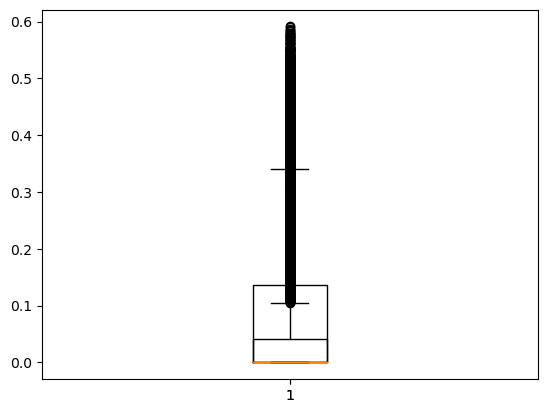

In [29]:
#Look at the average difference and percentual deviation incurred by installing all candidates
existing_actual = NN_evaluation.get_actual_from_dfs_out(all_executions[0],dfs_out)/maxs["out"]
full_actual = NN_evaluation.get_actual_from_dfs_out(all_executions[1],dfs_out)/maxs["out"]

differences = existing_actual - full_actual
deviation_existing = torch.div(differences,existing_actual) 

print(torch.mean(deviation_existing),torch.median(deviation_existing), torch.std(deviation_existing))
plt.boxplot(differences.detach().numpy())
plt.boxplot(deviation_existing.detach().numpy())

In [31]:
torch.min(full_actual)

tensor(0.0428, dtype=torch.float64)

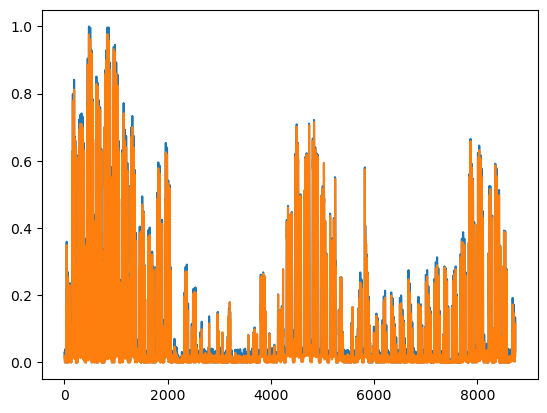

In [21]:
plt.plot(existing_actual)
#plt.plot(full_actual)
#plt.plot(differences)

In [12]:
#Collect difference and deviation incurred by individual candidates in dataframe
ics = DataLoading.list_investments_candidates_from_execs(executions=all_executions)
df_lb = pd.DataFrame()
for ic in ics:
    ix_P = [i for i, string in enumerate(all_executions) if ic in string and "PINT" in string]
    ix_T = [i for i, string in enumerate(all_executions) if ic in string and "TOOT" in string]
    ex_P  = all_executions[ix_P[0]]
    ex_T = all_executions[ix_T[0]]

    ex_actual_P = NN_evaluation.get_actual_from_dfs_out(ex_P,dfs_out)/maxs["out"]
    ex_actual_T = NN_evaluation.get_actual_from_dfs_out(ex_T,dfs_out)/maxs["out"]

    lb_P = existing_actual -ex_actual_P
    lb_T = - (full_actual - ex_actual_T)

    lb = (lb_P + lb_T)/2
    df_lb[ic] = lb
    #ic,ex_P,ex_T,lb.sum()
df_lb_dev = df_lb.div(existing_actual,axis=0)

<Axes: >

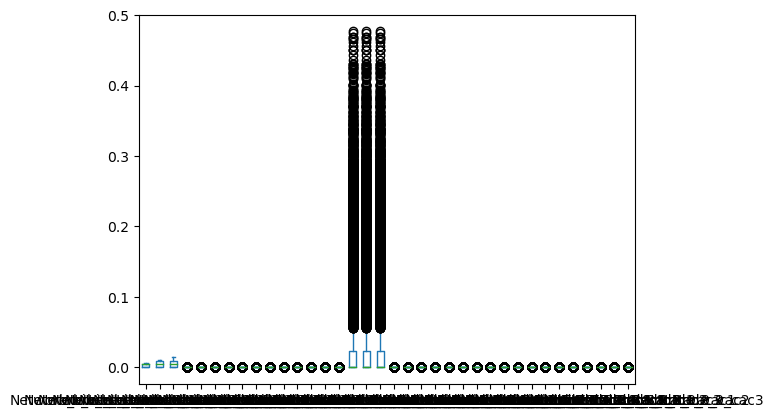

In [33]:
df_lb.plot(kind = "box")

In [32]:
df_lb.mean()

Network_Line_In_Node_1_Node_6_cac1    3.171218e-03
Network_Line_In_Node_1_Node_6_cac2    4.837323e-03
Network_Line_In_Node_1_Node_6_cac3    5.012082e-03
Network_Line_In_Node_2_Node_3_cac1   -3.250303e-06
Network_Line_In_Node_2_Node_3_cac2   -4.711480e-06
Network_Line_In_Node_2_Node_3_cac3   -6.096460e-06
Network_Line_In_Node_2_Node_6_cac1    6.547080e-06
Network_Line_In_Node_2_Node_6_cac2    9.068611e-06
Network_Line_In_Node_2_Node_6_cac3    1.112875e-05
Network_Line_In_Node_3_Node_4_cac1    1.827334e-05
Network_Line_In_Node_3_Node_4_cac2    1.826099e-05
Network_Line_In_Node_3_Node_4_cac3    1.823664e-05
Network_Line_In_Node_3_Node_6_cac1    5.148033e-06
Network_Line_In_Node_3_Node_6_cac2    7.896552e-06
Network_Line_In_Node_3_Node_6_cac3    1.070598e-05
Network_Line_In_Node_4_Node_5_cac1    3.926795e-02
Network_Line_In_Node_4_Node_5_cac2    3.926795e-02
Network_Line_In_Node_4_Node_5_cac3    3.926795e-02
Network_Line_In_Node_4_Node_6_cac1    1.439580e-05
Network_Line_In_Node_4_Node_6_c

In [105]:
#Model deviations
hyperloop_name = "rand_hours_3-bus_DC_0.3_v0.3_PF_0_20"
df_losses = pd.read_csv(f"Loss_results_csv/{hyperloop_name}.csv",index_col=0)
f = df_losses.Nb_hours_used >=1

loss_to_sort = "fy_l_mse"
xth_best = 1

row = NN_evaluation.find_xthbest_model_params_from_df(df_losses[f],loss_to_sort,xth_best)
m = NN_evaluation.create_model_and_load_state_from_row(row,input_size,inter_size,hyperloop_name,cluster_run=False)
prediction = m(t_in_fy.float())[0].squeeze().detach().numpy()

diff = prediction - t_out_fy.numpy().transpose()
dev = diff/prediction

[28, 42, 8, 3, 1]
OE_2900hours_(3, 1)h_256e_0.0025lr_0dor_Falsero_64bs_0ill_TrueMAE min_val
trained_models/rand_hours_3-bus_DC_0.3_v0.3_PF_0_20/min_val/model_OE_2900hours_(3, 1)h_256e_0.0025lr_0dor_Falsero_64bs_0ill_TrueMAE.pth


{'whiskers': [<matplotlib.lines.Line2D at 0x1fb32e5f520>,
 'caps': [<matplotlib.lines.Line2D at 0x1fb329d6ce0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1fb32e5f280>],
 'medians': [<matplotlib.lines.Line2D at 0x1fb329d7220>],
 'fliers': [<matplotlib.lines.Line2D at 0x1fb329d74c0>],
 'means': []}

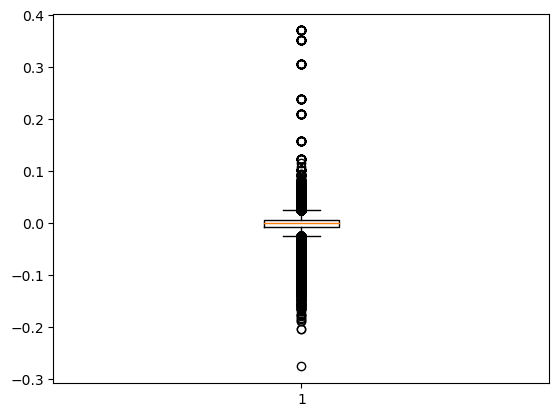

In [108]:
plt.boxplot(dev)